# Решение задачи классификации обращений клиентов с помощью языковой модели семейства BERT

###_Аннотация_

Данный проект рассматривает проблему обработки естественного языка и применение систем автоматической обработки естественного языка для классификации обращений клиентов на русском языке.

Ежедневно специализированные системы компаний собирают обращения клиентов со всех точек ее присутствия. Крупные компании успешно решают такие задачи благодаря большим и качественным наборам данных, но малые компании до сих пор обрабатывают обращения вручную из-за ограниченного набора данных и ресурсов. Однако в последние годы появилась возможность автоматической обработки естественного языка с высокой точностью благодаря использованию больших языковых моделей.

Целью данного проекта заключается в применении языковых моделей семейства BERT для автоматической обработки и классификации обращений. Для достижения этой цели используются передовые методы искусственного интеллекта.
Разработана программа на языке программирования Python с использованием библиотек машинного обучения. Техническое решение позволяет апробировать предобученные модели классификации данных, на основе которых создать оптимизированные модели классификации предмета обращения на основе текстов обращений с учетом специфики предметной области.

_Ключевые слова: BERT, Transformer классификация, машинное обучение, глубокое обучение, нейронные сети, языковая модель, обработка естественного языка_


## Алгоритм обучения модели BERT

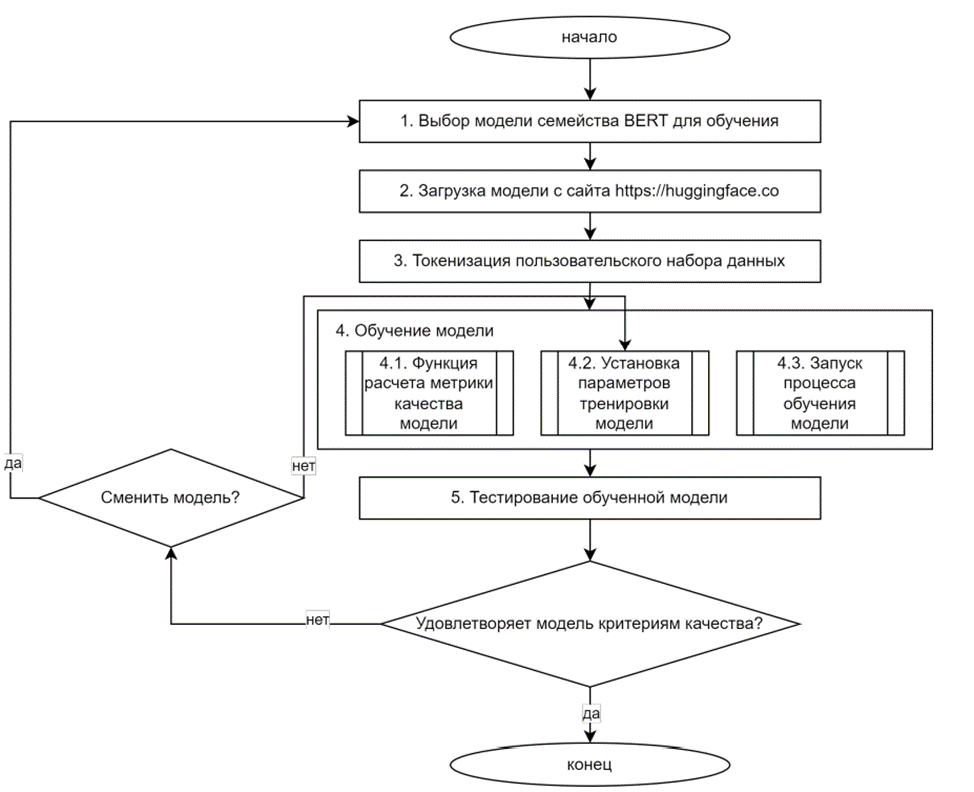

In [ ]:
!pip install transformers

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from tqdm import tqdm
from torch.utils.data import (TensorDataset,
                              DataLoader,
                              RandomSampler)

from keras.utils import pad_sequences
#from tensorflow.keras.utils import pad_sequences

from transformers import (AutoConfig,
                          AutoModelForSequenceClassification)
from transformers import AutoTokenizer
from transformers import AdamW
from transformers import (AutoModel,
                          BertTokenizer,
                          BertForSequenceClassification)

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [ ]:
#from random import randint
#from utils.ml.train_model import init_random_seed
#from utils.ml.visualize import config_my_plotting

#init_random_seed(42)
#config_my_plotting()

In [47]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.get_device_name(0))

Tesla T4


In [3]:
# загрузка данных
df = pd.read_excel("Реестр обращений клиентов (main).xlsx",
                    sheet_name="all", parse_dates=['DATE'])

In [7]:
# предметы обращений
df['SUBJECT'].value_counts()

карта                   5305
п/к                     3604
atm                     3433
ипт/бпт/птбск           2811
мобильное приложение    1272
смс                     1169
pos                      959
переводы                 719
сервис                   643
интернет банк            603
кредитование фл          357
рко фл                   322
касса                    274
вклады                   242
рко юл                   132
Name: SUBJECT, dtype: int64

In [8]:
# Присвоим каждому предмету индекс, для подачи в модель
subject_index = {i[1]:i[0] for i in enumerate(df.SUBJECT.unique())}

In [9]:
'''обратное преобразование - индекс метки в текст, этот словарь нам понадобится
   после обучения для большей наглядности, чтобы видеть, к какой категории товар отнесён моделью'''
subject_index_reverce = {i[0]:i[1] for i in enumerate(df.SUBJECT.unique())}

In [10]:
# Переведём все метки из набора данных в числа
df['sentences'] = df.ABOUT.values
df['label'] = [subject_index[i] for i in df.SUBJECT.values]

In [ ]:
# Каждому обращению клиента теперь соответсвует не название предмета обращения, а её индекс:
print(df['ABOUT'][42],' ',df['label'][42])

In [76]:
# Проверим, что все данные корректны
assert len(df['sentences']) == len(df['label']) == df.shape[0]

## Этап токенизаций

Подготовленный набор данных нужно токенизировать. Для этого мы воспользуемся уже предобученным токенизатором, идущим вместе с моделями BERT.

Каждый корпус мы приведём к виду, который требуется Bert, затем разобъём выборку на обучающую и тестовую, для последующей проверки качества.

Специальные токены Берта:

* `[CLS]` - начало последовательности
* `[SEP]` - разделение двух предложений

Мы будем обрамлять наши корпсу этими токенами.


In [12]:
df['sentences'] = ['[CLS] ' + sentence + ' [SEP]' for sentence in df['sentences']]

In [13]:
train_sentences, test_sentences, train_label, test_label = train_test_split(df['sentences'], df['label'], test_size=0.1, stratify=df['label'])

In [14]:
df_train = pd.DataFrame(train_sentences.values, columns = ['train_sentences'])
df_train['train_label'] = pd.DataFrame(train_label.values, columns = ['train_label'])

In [15]:
df_test = pd.DataFrame(test_sentences.values, columns = ['test_sentences'])
df_test['test_label'] = pd.DataFrame(test_label.values, columns = ['test_label'])

In [16]:
len(train_sentences), len(test_sentences)

(19660, 2185)

Загрузим наш токенизатор. Они идут вместе с предобученными моделями

1. [BERT multilingual base model (cased)](https://huggingface.co/bert-base-multilingual-cased).
2. [Rubert-base-cased](https://huggingface.co/DeepPavlov/rubert-base-cased).
3. [BERT large model (uncased)](https://huggingface.co/ai-forever/sbert_large_nlu_ru).

Загружать будем с помощью метода Pytorch `torch.hub.load`.

In [ ]:
!pip install sentencepiece sacremoses importlib_metadata

In [18]:
tokenizer_1 = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'bert-base-multilingual-cased')

/usr/local/lib/python3.10/dist-packages/torch/hub.py:286: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/huggingface/pytorch-transformers/zipball/main" to /root/.cache/torch/hub/main.zip


In [19]:
tokenizer_2 = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'DeepPavlov/rubert-base-cased')

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main


In [20]:
tokenizer_3 = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'ai-forever/sbert_large_nlu_ru')

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main


In [21]:
# Токенизируем нашу обучающую выборку

tokenized_texts_1 = [tokenizer_1.tokenize(sent) for sent in train_sentences]
tokenized_texts_2 = [tokenizer_2.tokenize(sent) for sent in train_sentences]
tokenized_texts_3 = [tokenizer_3.tokenize(sent) for sent in train_sentences]

Token indices sequence length is longer than the specified maximum sequence length for this model (814 > 512). Running this sequence through the model will result in indexing errors


In [22]:
# Посмотрим, что получилось
# Сомволы номеров отмечают то, что данный токен - продолжение слова

print(df_train.train_sentences[1])
print(tokenized_texts_1[1])
print(tokenized_texts_2[1])
print(tokenized_texts_3[1])

[CLS] перевыпуск карты в связи с окончанием срока действия на visa gold без пакета лояльности классик [SEP]
['[CLS]', 'пер', '##ев', '##ып', '##ус', '##к', 'карты', 'в', 'связи', 'с', 'око', '##н', '##чан', '##ием', 'срок', '##а', 'действия', 'на', 'visa', 'gold', 'без', 'пак', '##ета', 'ло', '##ял', '##ьности', 'класс', '##ик', '[SEP]']
['[CLS]', 'перевып', '##уск', 'карты', 'в', 'связи', 'с', 'окончанием', 'срока', 'действия', 'на', 'vis', '##a', 'go', '##ld', 'без', 'пакета', 'лояльности', 'классик', '[SEP]']
['[CLS]', 'перевы', '##пуск', 'карты', 'в', 'связи', 'с', 'окончанием', 'срока', 'де', '##ист', '##вия', 'на', 'vis', '##a', 'gold', 'без', 'пакета', 'лояльности', 'классик', '[SEP]']


In [23]:
# ииндексы токенов

input_ids_1 = [tokenizer_1.convert_tokens_to_ids(x) for x in tokenized_texts_1]
input_ids_2 = [tokenizer_2.convert_tokens_to_ids(x) for x in tokenized_texts_2]
input_ids_3 = [tokenizer_3.convert_tokens_to_ids(x) for x in tokenized_texts_3]

Нужно выбрать размер входной последовательности, подаваемой нейросети. Он должен быть фиксированным, наши сэмплы имеют различную длину.

Поэтому посмотрим на распределение количества токенов в сэмплах и попытаемся определить оптимальный размер.

Выбрав размер, мы приведём все сэмплы к единому виду: последовательности большого размера будут образаны, последовательности малого размера дополнятся паддингами - специальными нулевыми токенами.

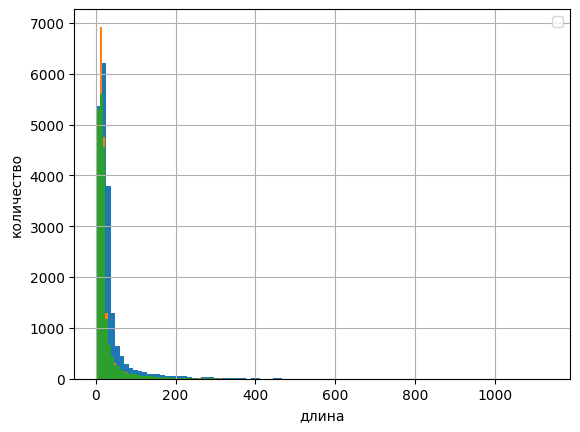

In [24]:
# Соберём все размеры последовательностей

lenths_1 = [len(sent) for sent in tokenized_texts_1]
lenths_2 = [len(sent) for sent in tokenized_texts_2]
lenths_3 = [len(sent) for sent in tokenized_texts_3]

# Посмотрим, как они распределяются

plt.hist(lenths_1, bins=100)
plt.hist(lenths_2, bins=100)
plt.hist(lenths_3, bins=100)
plt.grid(True)
plt.legend(loc = 'best')
plt.xlabel('длина')  # Set the x-axis label
plt.ylabel('количество')  # Set the y-axis label
#plt.title('Гистограма')  # Set the title of the plot
plt.show()

In [25]:
# Выравниваем наш набор данных, возьмём размер, равный 75

x_mean = 75

input_ids_1 = pad_sequences(input_ids_1, maxlen=x_mean, dtype='long',
                                                    truncating='post',
                                                    padding='post')
input_ids_2 = pad_sequences(input_ids_2, maxlen=x_mean, dtype='long',
                                                    truncating='post',
                                                    padding='post')
input_ids_3 = pad_sequences(input_ids_3, maxlen=x_mean, dtype='long',
                                                    truncating='post',
                                                    padding='post')

In [26]:
# В результате получилось следующее, как видно если меньше 75 токенов то в конец были добавлены паддинги

print(input_ids_1[42], '\n',input_ids_2[42], '\n', input_ids_3[42])

[  101   556 10351 12528 14958 53541 12743 10375 12709 32418 48716 12634
 10513 32858 11194 41065   102     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0] 
 [  101 12442 47740   862 47363  1699 66807 25987  2059 12725   102     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0] 
 [  101   117   380 22659   385 38752   672 32379 15108   767  4352   102
     0 

In [27]:
'''Создадим маску внимания для каждого корпуса нашей обучающей выборки.
Единицами отметим токены, которые нужно учитывать при обучении и вычислении градиентов, нулями - те, которые следует пропустить.'''

attention_masks_1 = [[float(i>0) for i in seq] for seq in input_ids_1]
attention_masks_2 = [[float(i>0) for i in seq] for seq in input_ids_2]
attention_masks_3 = [[float(i>0) for i in seq] for seq in input_ids_3]

print(attention_masks_1[42])
print(attention_masks_2[42])
print(attention_masks_3[42])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

In [28]:
# Проверим что каждая маска соответсвует своей последовательности

assert len(input_ids_1[42]) == len(attention_masks_1[42])
assert len(input_ids_2[42]) == len(attention_masks_2[42])
assert len(input_ids_3[42]) == len(attention_masks_3[42])

In [29]:
'''Разобъём наш train на обучающую выборку и тестовую - для того,
чтобы проверять качество в ходе дообучения модели: нужно разделить как последовательности, так и их маски.'''

train_inputs_1, validation_inputs_1, train_labels_1, validation_labels_1 = train_test_split(
    input_ids_1, train_label,
    random_state=42,
    test_size=0.1,
    stratify=train_label
)

train_masks_1, validation_masks_1, _1, _1 = train_test_split(
    attention_masks_1,
    input_ids_1,
    random_state=42,
    test_size=0.1,
    #stratify=attention_masks_1
)

assert len(train_inputs_1) == len(train_labels_1) == len(train_masks_1)
assert len(validation_inputs_1) == len(validation_labels_1) == len(validation_masks_1)

In [30]:
train_inputs_2, validation_inputs_2, train_labels_2, validation_labels_2 = train_test_split(
    input_ids_2, train_label,
    random_state=42,
    test_size=0.1,
    stratify=train_label
)

train_masks_2, validation_masks_2, _2, _2 = train_test_split(
    attention_masks_2,
    input_ids_2,
    random_state=42,
    test_size=0.1,
    #stratify=attention_masks_1
)

assert len(train_inputs_2) == len(train_labels_2) == len(train_masks_2)
assert len(validation_inputs_2) == len(validation_labels_2) == len(validation_masks_2)

In [31]:
train_inputs_3, validation_inputs_3, train_labels_3, validation_labels_3 = train_test_split(
    input_ids_3, train_label,
    random_state=42,
    test_size=0.1,
    stratify=train_label
)

train_masks_3, validation_masks_3, _3, _3 = train_test_split(
    attention_masks_3,
    input_ids_3,
    random_state=42,
    test_size=0.1,
    #stratify=attention_masks_3
)

assert len(train_inputs_3) == len(train_labels_3) == len(train_masks_3)
assert len(validation_inputs_3) == len(validation_labels_3) == len(validation_masks_3)

## Инициализация DataLoader'ов

Переведём наши данные в тип Тензор, с которым работает Pytorch и инициализируем уже готовый DataLoader из этой библиотеки.

In [32]:
train_inputs_1 = torch.tensor(train_inputs_1)
train_labels_1 = torch.tensor(train_labels_1.values)
train_masks_1 = torch.tensor(train_masks_1)

validation_inputs_1 = torch.tensor(validation_inputs_1)
validation_labels_1 = torch.tensor(validation_labels_1.values)
validation_masks_1 = torch.tensor(validation_masks_1)

In [33]:
train_inputs_2 = torch.tensor(train_inputs_2)
train_labels_2 = torch.tensor(train_labels_2.values)
train_masks_2 = torch.tensor(train_masks_2)

validation_inputs_2 = torch.tensor(validation_inputs_2)
validation_labels_2 = torch.tensor(validation_labels_2.values)
validation_masks_2 = torch.tensor(validation_masks_2)

In [34]:
train_inputs_3 = torch.tensor(train_inputs_3)
train_labels_3 = torch.tensor(train_labels_3.values)
train_masks_3 = torch.tensor(train_masks_3)

validation_inputs_3 = torch.tensor(validation_inputs_3)
validation_labels_3 = torch.tensor(validation_labels_3.values)
validation_masks_3 = torch.tensor(validation_masks_3)

В ходе экспериментов можно подобрать разные размеры батча.

Но нужно учитывать то, что при больших размерах батча на видеокарте может не хватить памяти, при слишком же малых размерах батча обучение будет нестабильным.

In [35]:
from torch.utils.data.sampler import SequentialSampler
from torch.utils.data import DataLoader

In [36]:
''' Обёртка для работы с Тензор-датасетами, в Pytorch есть и другие,
 также можно и свою обёртку написать, для нашей же задачи вполне хватит уже существующих
 в библиотеке инструментов. Используя их мы существенно сокращаем свой код. '''

train_data_1 = TensorDataset(train_inputs_1, train_masks_1, train_labels_1)
train_dataloader_1 = DataLoader(
    train_data_1,
    # Данные по батчам разбиваем произвольно с помощью RandomSampler
    sampler=RandomSampler(train_data_1),
    batch_size=32
)
validation_data_1 = TensorDataset(validation_inputs_1, validation_masks_1, validation_labels_1)
validation_dataloader_1 = DataLoader(
    validation_data_1,
    sampler=SequentialSampler(validation_data_1),
    batch_size=32
)

In [68]:
train_data_2 = TensorDataset(train_inputs_2, train_masks_2, train_labels_2)
train_dataloader_2 = DataLoader(
    train_data_2,
    # Данные по батчам разбиваем произвольно с помощью RandomSampler
    sampler=RandomSampler(train_data_2),
    batch_size=32
)
validation_data_2 = TensorDataset(validation_inputs_2, validation_masks_2, validation_labels_2)
validation_dataloader_2 = DataLoader(
    validation_data_2,
    sampler=SequentialSampler(validation_data_2),
    batch_size=32
)

In [38]:
train_data_3 = TensorDataset(train_inputs_3, train_masks_3, train_labels_3)
train_dataloader_3 = DataLoader(
    train_data_3,
    # Данные по батчам разбиваем произвольно с помощью RandomSampler
    sampler=RandomSampler(train_data_3),
    batch_size=32
)
validation_data_3 = TensorDataset(validation_inputs_3, validation_masks_3, validation_labels_3)
validation_dataloader_3 = DataLoader(
    validation_data_3,
    sampler=SequentialSampler(validation_data_3),
    batch_size=32
)

# Дообучение моделей

Загружаем веса предобученной модели и запускаем процесс дообучения на наших данных.

Т.к. в результате мы хотим получить не языковую модель, а мультиклассовый классификатор, укажем это при настройках.

В библиотеке Transformers уже имплементированы классы для различных задач. Нам понадобится `AutoModelForSequenceClassification`.

Использовав этот класс, мы возьмём предобученный Bert, добавив ему на выход один полносвязный слой, который и будет решать нашу задачу классификации. По умолчанию обёртка `AutoModelForSequenceClassification` (или `BertForSequenceClassification`) использует бинарную классификацию. Нам же нужна мультиклассовая, поэтому укажем это в конфигурации.

In [39]:
# Bert-base-multilingual-cased
config_1 = AutoConfig.from_pretrained('bert-base-multilingual-cased',
                                    num_labels=len(subject_index),
                                    id2label=subject_index_reverce,
                                    label2id=subject_index)

# Загружаем модель, передаём ей наш конфиг
model_1 = AutoModelForSequenceClassification.from_pretrained('bert-base-multilingual-cased', config=config_1)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [40]:
# DeepPavlov/rubert-base-cased
config_2 = AutoConfig.from_pretrained('DeepPavlov/rubert-base-cased',
                                    num_labels=len(subject_index),
                                    id2label=subject_index_reverce,
                                    label2id=subject_index)
# Загружаем модель, передаём ей наш конфиг
model_2 = AutoModelForSequenceClassification.from_pretrained('DeepPavlov/rubert-base-cased', config=config_2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [41]:
# Sbert_large_nlu_ru
config_3 = AutoConfig.from_pretrained('sberbank-ai/sbert_large_nlu_ru',
                                    num_labels=len(subject_index),
                                    id2label=subject_index_reverce,
                                    label2id=subject_index)
# Загружаем модель, передаём ей наш конфиг
model_3 = AutoModelForSequenceClassification.from_pretrained('sberbank-ai/sbert_large_nlu_ru', config=config_3)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sberbank-ai/sbert_large_nlu_ru and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [42]:
# Гипепараметры модели. Их можно изменять

param_optimizer_1 = list(model_1.named_parameters())
param_optimizer_2 = list(model_2.named_parameters())
param_optimizer_3 = list(model_3.named_parameters())

In [43]:
# Отправим на видеокарту (Cuda ядра), наглядно рассмотрим архитектуру Bert

print('№1 \n',model_1.cuda())
print('№2 \n',model_2.cuda())
print('№3 \n',model_3.cuda())

№1 
 BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=

К выходу Bert был добавлен слой:

```(classifier): Linear(in_features=1024, out_features=15, bias=True)```

На выходе получим 15 вероятностей принадлежности текста той или иной метке.

In [44]:
'''В качестве оптимизатора будем использовать оптимизированный Adam (adaptive moment estimation)
    for name, _ in param_optimizer:
        print(name)'''

no_decay = ['bias', 'gamma', 'beta']

optimizer_grouped_parameters_1 = [
    {'params': [p for n, p in param_optimizer_1 if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer_1 if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer_grouped_parameters_2 = [
    {'params': [p for n, p in param_optimizer_2 if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer_2 if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer_grouped_parameters_3 = [
    {'params': [p for n, p in param_optimizer_3 if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer_3 if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [45]:
optimizer_1 = torch.optim.AdamW(optimizer_grouped_parameters_1, lr=2e-5)
optimizer_2 = torch.optim.AdamW(optimizer_grouped_parameters_2, lr=2e-5)
optimizer_3 = torch.optim.AdamW(optimizer_grouped_parameters_3, lr=2e-5)

Для получения хорошего результата достаточно 2 - 4 эпох. Но даже один прогон покажет хороший результат - для нашего датасета и задачи это именно так.

### Обучение моделей

In [48]:
%%time

# Обучение модели №1 - bert-base-multilingual-cased
train_loss_1, train_loss_set_1 = 0, []

# Переводим модель в training mode
model_1.train()

for step, batch in tqdm(enumerate(train_dataloader_1), total = len(train_dataloader_1)):
    # Переводим данные на видеокарту
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    # Обнуляем градиенты
    optimizer_1.zero_grad()

    # Прогоняем данные по слоям нейросети
    loss = model_1(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

    train_loss_set_1.append(loss[0].item())

    # Обратный прогон
    loss[0].backward()

    # Шаг
    optimizer_1.step()

    # Обновляем loss
    train_loss_1 += loss[0].item()
    #print(f'Loss: {loss[0].item()}')
print('*'*20)
print(f'Лосс на обучении: {train_loss_1 / len(train_dataloader_1)}')

100%|██████████| 553/553 [03:52<00:00,  2.38it/s]

********************
Лосс на обучении: 0.9506779822906577
CPU times: user 3min 32s, sys: 1.32 s, total: 3min 34s
Wall time: 3min 52s


In [ ]:
# сохранение модели №1 bert-base-multilingual-cased
model_1.save_pretrained('model/bert-base-multilingual-cased/')
tokenizer_1.save_pretrained('model/bert-base-multilingual-cased/')

In [69]:
%%time

# Обучение модели №2 rubert-base-cased
train_loss_2, train_loss_set_2 = 0, []

# Переводим модель в training mode
model_2.train()

for step, batch in tqdm(enumerate(train_dataloader_2), total = len(train_dataloader_2)):
    # Переводим данные на видеокарту
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    # Обнуляем градиенты
    optimizer_2.zero_grad()

    # Прогоняем данные по слоям нейросети
    loss = model_2(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

    train_loss_set_2.append(loss[0].item())

    # Обратный прогон
    loss[0].backward()

    # Шаг
    optimizer_2.step()

    # Обновляем loss
    train_loss_2 += loss[0].item()
    #print(f'Loss: {loss[0].item()}')
print('*'*20)
print(f'Лосс на обучении: {train_loss_2 / len(train_dataloader_2)}')

100%|██████████| 553/553 [03:50<00:00,  2.40it/s]

********************
Лосс на обучении: 0.7688875374321912
CPU times: user 3min 46s, sys: 971 ms, total: 3min 47s
Wall time: 3min 50s


In [ ]:
# сохранение модели №2 - rubert-base-cased/
model_2.save_pretrained('model/rubert-base-cased/')
tokenizer_2.save_pretrained('model/rubert-base-cased/')

In [ ]:
%%time

# Обучение модели №3 sbert_large_nlu_ru
train_loss_3, train_loss_set_3 = 0, []

# Переводим модель в training mode
model_3.train()

for step, batch in tqdm(enumerate(train_dataloader_3), total = len(train_dataloader_3)):
    # Переводим данные на видеокарту
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    # Обнуляем градиенты
    optimizer_3.zero_grad()

    # Прогоняем данные по слоям нейросети
    loss = model_3(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

    train_loss_set_3.append(loss[0].item())

    # Обратный прогон
    loss[0].backward()

    # Шаг
    optimizer_3.step()

    # Обновляем loss
    train_loss_3 += loss[0].item()
    #print(f'Loss: {loss[0].item()}')
print('*'*20)
print(f'Лосс на обучении: {train_loss_3 / len(train_dataloader_3)}')

100%|██████████| 553/553 [12:24<00:00,  1.35s/it]

********************
Лосс на обучении: 0.8050089680318591
CPU times: user 10min 33s, sys: 1min 22s, total: 11min 55s
Wall time: 12min 24s


In [ ]:
# сохранение модели №3 - sbert_large_nlu_ru
model_3.save_pretrained('model/sbert_large_nlu_ru/')
tokenizer_3.save_pretrained('model/sbert_large_nlu_ru/')

In [ ]:
# посмотрим, как обучалась наша модель
plt.plot(train_loss_set_1)
plt.plot(train_loss_set_2)
plt.plot(train_loss_set_3)
plt.title("Loss на обучении")
plt.xlabel("Батчи")
plt.ylabel("Потери")
plt.grid(True)
plt.show()

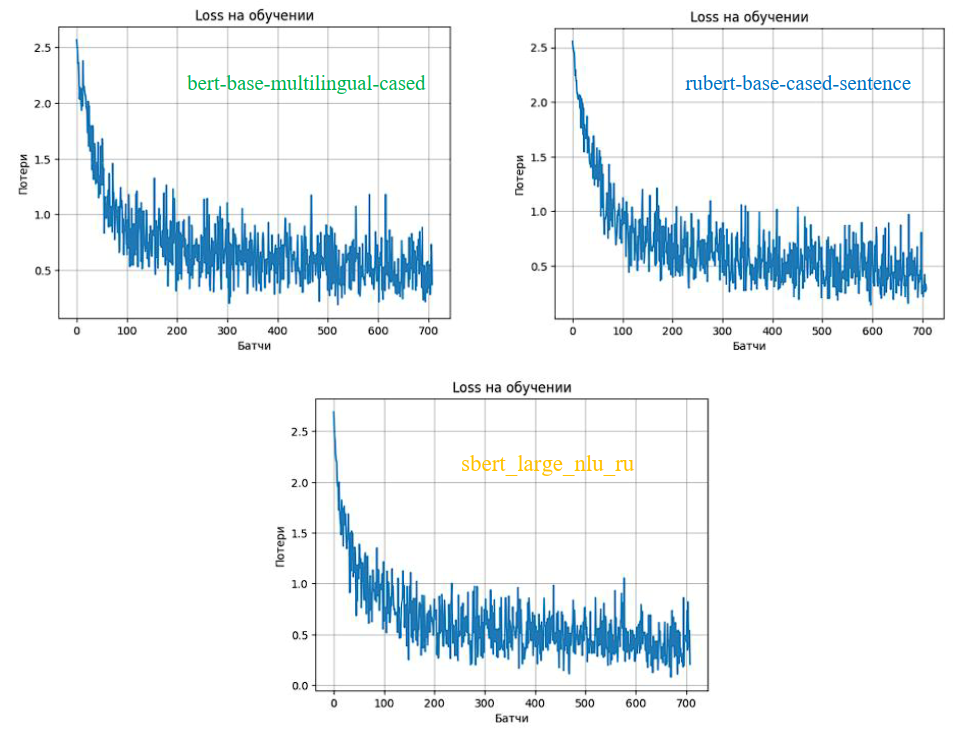

Как видим, модели обучились достаточно быстро, далее идут лишь флуктуации без улучшений качества.



# Валидация

Проверим работу модели на тестовой выборке.

In [61]:
%%time

# Переводим модель в evaluation mode
model_1.eval()

valid_preds_1, valid_labels_1 = [], []

for batch in tqdm(validation_dataloader_1, total = len(validation_dataloader_1)):
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)

    b_input_ids, b_input_mask, b_labels = batch

    # Вычислять градиенты не нужно
    with torch.no_grad():
        logits = model_1(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Перемещаем логиты и метки на CPU
    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    batch_preds = np.argmax(logits, axis=1)
    batch_labels = label_ids #np.concatenate(label_ids)

    valid_preds_1.extend(batch_preds)
    valid_labels_1.extend(batch_labels)

100%|██████████| 62/62 [00:07<00:00,  7.89it/s]

CPU times: user 6.89 s, sys: 33.6 ms, total: 6.92 s
Wall time: 7.86 s


In [73]:
%%time

# Переводим модель в evaluation mode
model_2.eval()

valid_preds_2, valid_labels_2 = [], []

for batch in tqdm(validation_dataloader_2, total = len(validation_dataloader_2)):
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)

    b_input_ids, b_input_mask, b_labels = batch

    # Вычислять градиенты не нужно
    with torch.no_grad():
        logits = model_2(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Перемещаем логиты и метки на CPU
    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    batch_preds = np.argmax(logits, axis=1)
    batch_labels = label_ids #np.concatenate(label_ids)

    valid_preds_2.extend(batch_preds)
    valid_labels_2.extend(batch_labels)

100%|██████████| 62/62 [00:07<00:00,  8.01it/s]

CPU times: user 7.48 s, sys: 32.8 ms, total: 7.51 s
Wall time: 7.75 s


In [ ]:
%%time

# Переводим модель в evaluation mode
model_3.eval()

valid_preds_3, valid_labels_3 = [], []

for batch in tqdm(validation_dataloader_3, total = len(validation_dataloader_3)):
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)

    b_input_ids, b_input_mask, b_labels = batch

    # Вычислять градиенты не нужно
    with torch.no_grad():
        logits = model_3(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Перемещаем логиты и метки на CPU
    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    batch_preds = np.argmax(logits, axis=1)
    batch_labels = label_ids #np.concatenate(label_ids)

    valid_preds_3.extend(batch_preds)
    valid_labels_3.extend(batch_labels)

100%|██████████| 62/62 [00:29<00:00,  2.11it/s]

CPU times: user 18.7 s, sys: 232 ms, total: 18.9 s
Wall time: 29.4 s


Посмотрим на качество нашей модели по каждой из категорий. Как видно, при определении каждой из категорий, наша модель справляется сравнительно хорошо. И это даже при том, что мы использовали несбалансированную выборку.

In [75]:
#print(classification_report(valid_labels_1, valid_preds_1, target_names=subject_index_reverce.values()))
#print(classification_report(valid_labels_2, valid_preds_2, target_names=subject_index_reverce.values()))
#print(classification_report(valid_labels_3, valid_preds_3, target_names=subject_index_reverce.values()))

#### Отчет качества классификации модели на тестовой выборке

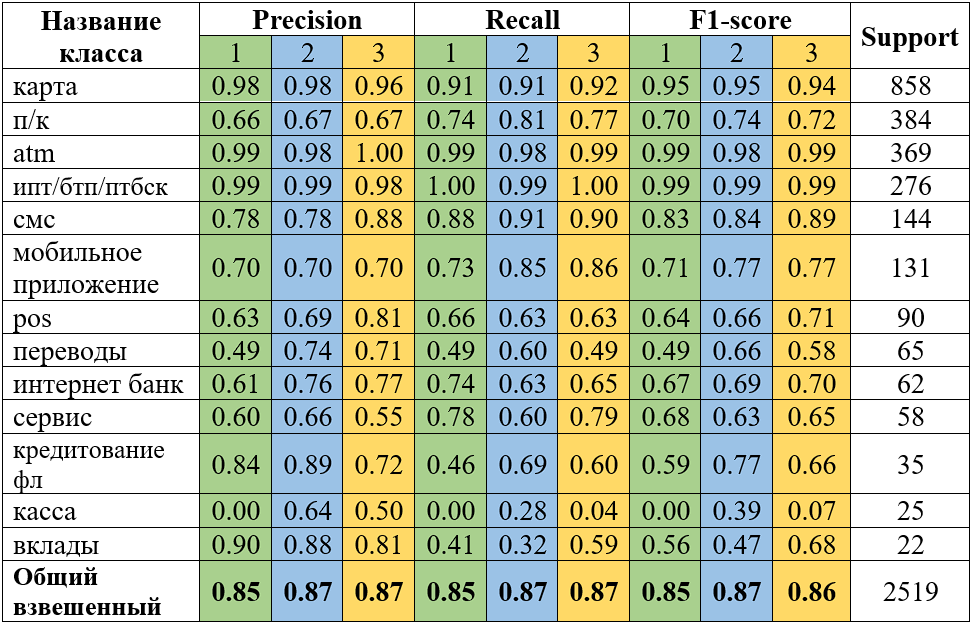

Заметим, что дисбаланс классов сильно повлиял на качество моделей. Для получения более точных предсказаний необходимо обогащать обучающий набор данных новыми наблюдениями.
В ходе проведения экспериментов также были предприняты попытки исключить из набора данных те классы, которые представлены малым количеством записей из-за чего модель их плохо предсказывала. Это помогло улучшить общие показателей качества модели. Представленная выше стратегия является компромиссом между точностью предсказаний и учетом количества классов в модели.


In [ ]:
def pred_model():
    ''' функция загружает сохраненные модели и предсказывает предмет обращения на основе входного текста
    '''

    path = 'model/' #путь к дириктории
    name_model = ['bert-base-multilingual-cased',
                  'rubert-base-cased',
                  'sbert_large_nlu_ru']
    answer = {}
    title = input()
    for i in name_model:
        #Загрузка модели
        config = AutoConfig.from_pretrained(path + i)
        tokenizer = AutoTokenizer.from_pretrained(path + i, pad_to_max_length=True)
        model = AutoModelForSequenceClassification.from_pretrained(path + i, config=config)

        model.to('cpu')
        model.eval()

        tokens = tokenizer.encode(title, add_special_tokens=True)
        tokens_tensor = torch.tensor([tokens])
        with torch.no_grad():
            logits = model(tokens_tensor)
        # Логиты по каждой категории
        logits = logits[0].detach().numpy()
        # Выбираем наиболее вероятную категорию
        predicted_class = np.argmax(logits, axis=1)

        answer[i] = subject_index_reverce[str(predicted_class[0])]
        print(f'Модель:{i} ====> Ответ: {subject_index_reverce[str(predicted_class[0])]}')

In [ ]:
'''
1. Нахожусь за границей, не приходят смс от банка, необходимые для покупки билетов! Что делать? От сбербанка приходят без пробле эм
Модель:bert-base-multilingual-cased ====> Ответ: смс
Модель:rubert-base-cased ====> Ответ: смс
Модель:sbert_large_nlu_ru ====> Ответ: смс

2. Добрый день! Как установить ограничения по покупкам в интернете, чтобы с подтверждением смс-кода?
Модель:bert-base-multilingual-cased ====> Ответ: смс
Модель:rubert-base-cased ====> Ответ: смс
Модель:sbert_large_nlu_ru ====> Ответ: смс

3. Не выданы д/с в АТМ 225 в сумме 150 000 руб.  В списке нет ATM 225, поэтому выбран 184
Модель:bert-base-multilingual-cased ====> Ответ: п/к
Модель:rubert-base-cased ====> Ответ: п/к
Модель:sbert_large_nlu_ru ====> Ответ: atm

'''